In [96]:
from skimage.io import imshow
from scipy.misc import imread
from keras.applications.xception import Xception
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from keras.models import Model
from scipy.misc import imresize
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Dropout, Dense, Activation, Conv2D, MaxPooling2D, Flatten

In [74]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            filename, class_id = line.rstrip('\n').split(',')
            res[filename] = int(class_id)
    return res

In [75]:
def get_resized(data, path, filename):
    img = imread(path + '/' + filename, mode='RGB')
    class_id = data[filename]
    img_resized = imresize(img, size=(299, 299), interp='cubic')
    return img_resized, class_id

In [110]:
def load_images(data, path, n=10000):
    X = []
    y = []
    for filename in list(data.keys())[:n]:
        img_resized, class_id = get_resized(data, path, filename)
        X.append(img_resized.reshape(299, 299, 3))
        y.append(class_id)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [111]:
path = '00_input/train/images'

In [112]:
data = read_csv(join('00_input/train', 'gt.csv'))

In [113]:
X, y = load_images(data, path)

/home/nimloth/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/home/nimloth/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [114]:
new_y = []
for y_value in y:
    y_new_value = np.zeros(50)
    y_new_value[y_value] = 1.
    new_y.append(y_new_value)
y = np.array(new_y)

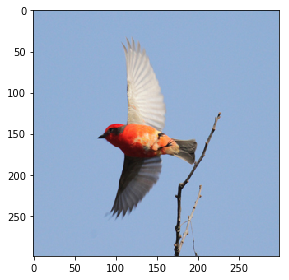

(50,)


In [122]:
imshow(X[345])
plt.show()
print(y[5].shape)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
base_model = Xception(include_top=False, weights='imagenet')
# add a global spatial average pooling layer
x = base_model.output
x = Flatten(input_shape=x.shape)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='elu')(x)
x = Dropout(0.9)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(500, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

ValueError: The shape of the input to "Flatten" is not fully defined (got (None, None, 2048). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

In [125]:
for layer in base_model.layers:
    layer.trainable = False

In [126]:
start = 0.03
stop = 0.001
nb_epoch = 10

In [127]:
early_stop = EarlyStopping(patience=100)
learning_rates = np.linspace(start, stop, nb_epoch)
change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

In [128]:
sgd = optimizers.SGD(lr=start, momentum=0.9, nesterov=True)

In [129]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy')

In [130]:
model.fit(X_train, y_train,
          epochs=nb_epoch,
          batch_size=32,
          validation_data=(X_test, y_test), 
          callbacks=[change_lr, early_stop])

ValueError: Error when checking target: expected dense_6 to have 4 dimensions, but got array with shape (2000, 50)

In [117]:
proba = model.predict_proba(X)


6000/6000 [==============================] - 20s 3ms/step


/home/nimloth/anaconda3/lib/python3.5/site-packages/keras/models.py:1024: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


In [118]:
print(proba[0])

[-0.60019559 -0.5351702  -0.21739583 -0.55906391  0.19693628 -0.55464309
  0.58038014 -0.55003673 -0.49300161 -0.36980423 -0.34906572 -0.37910879
 -0.21471494 -0.36589599  0.22018082 -0.36741939  0.35593647 -0.39174932
  0.50556904 -0.3750397  -0.0109343   0.04583376 -0.27022481  0.36040992
  0.00360273  0.38010228  0.26799774  0.35360378]


In [516]:
X_test, y_test = load_images(path, n=100)

In [119]:
y_pred = model.predict_proba(X_test)


1200/1200 [==============================] - 4s 3ms/step


/home/nimloth/anaconda3/lib/python3.5/site-packages/keras/models.py:1024: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


In [518]:
# from sklearn.metrics import mean_squared_error

In [129]:
# print(mean_squared_error(y_true=y_test, y_pred=y_pred) * 64)

In [132]:
x_dots_resized = y_pred[130][::2]
y_dots_resized = y_pred[130][1::2]
img_resized = X_test[130].reshape(64, 64)

In [133]:
for i in range(0, len(y_dots_resized)):
    img_resized[int(y_dots_resized[i] * 32 + 32)][int(x_dots_resized[i] * 32 + 32)] = 1

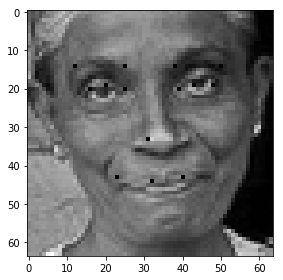

In [134]:
imshow(img_resized)
plt.show()